In [1]:
##### v1 #####
##### This main notebook is designed to be able to plot climatologies and composites without having to run every #####
##### calculation and take way too long.                                                                         #####

In [2]:
# Import packages here
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
from cartopy import config
import cartopy.crs as ccrs

import climlab
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [33]:
# Load all data variables
%run /data/keeling/a/tjhanke2/enso-energy-budget/Data/get_data_variables_fncs.ipynb

In [5]:
# This area is to be used as the user options section. Determine what needs to be plotted here. 
# 0 = don't plot, 1 = do plot
plot_clim = 1
plot_trends = 1
plot_enso_composites = 1
plot_model_cre = 1
plot_ceres_cre = 1
compare_cre = 1

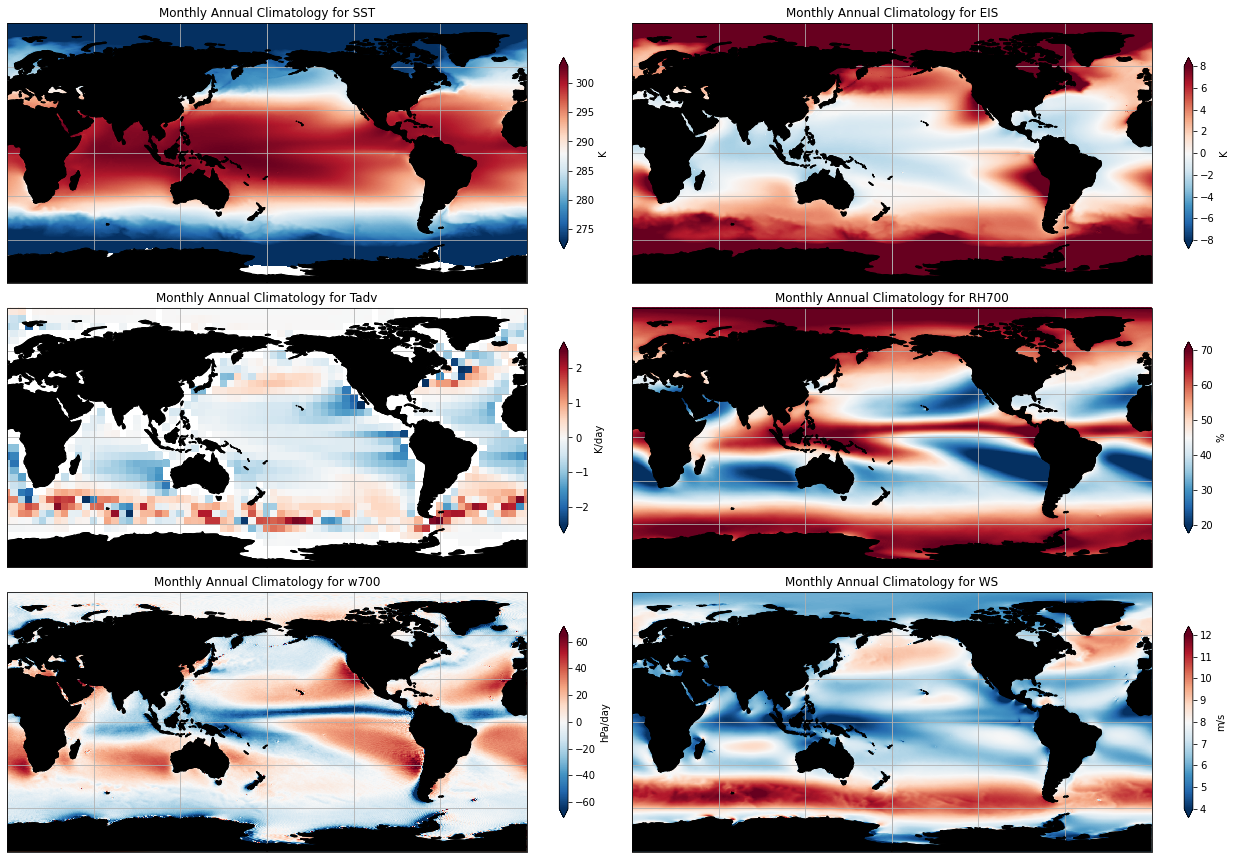

In [7]:
# Get climatological plots
if plot_clim == 1:
    %run ./get_clim_plot.ipynb
    
    get_clim_plot()

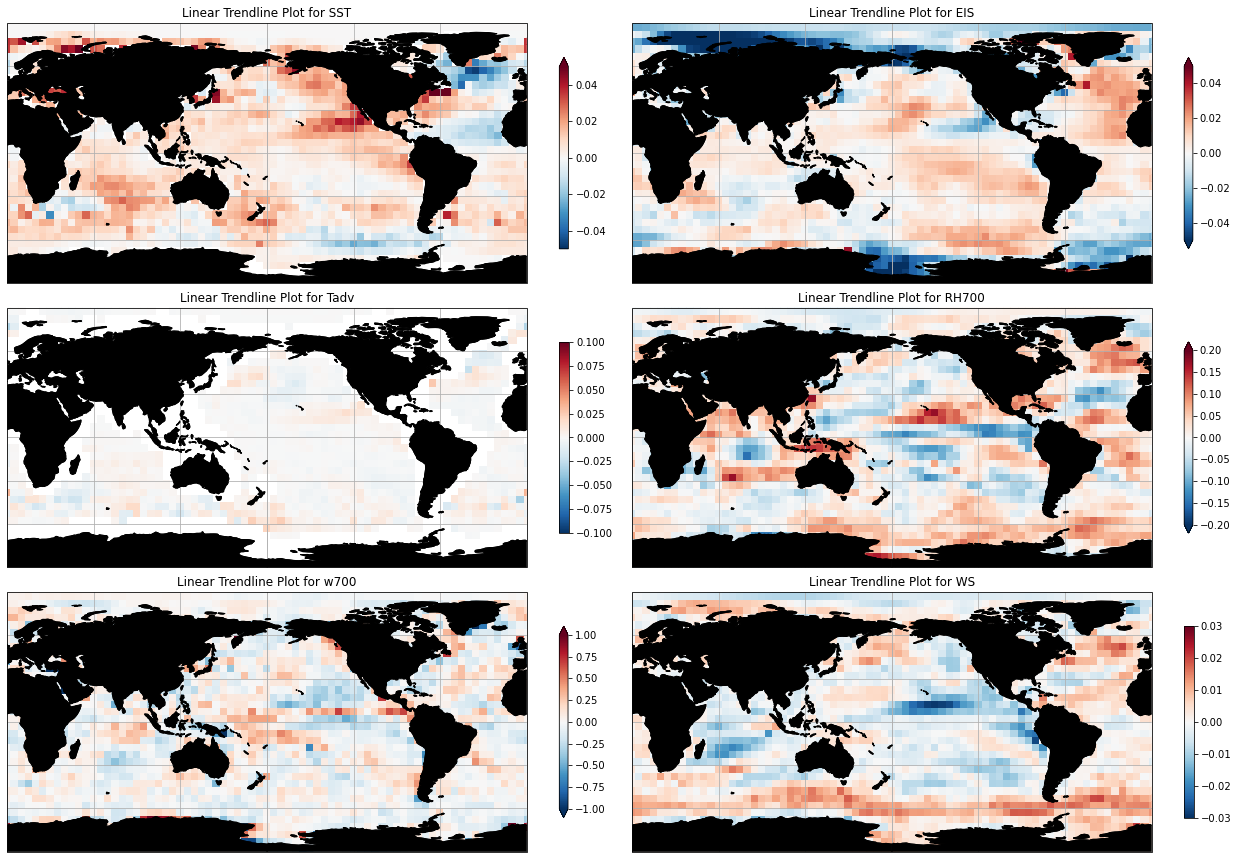

In [10]:
# Get linear trend plots
if plot_trends == 1:
    %run ./get_trend_plot.ipynb
    
    get_trend_plot()

In [23]:
path = '/data/keeling/a/tjhanke2/enso-energy-budget/Data/processed_data/ccf_anom_lo_res/nino3_4/'

In [24]:
nino34 = xr.open_dataset(path+'nino34_index.nc')

In [31]:
nino34.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (time: 210)>
array(['none', 'nino', 'nino', ..., 'none', 'none', 'none'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-01 2002-08-01 ... 2019-12-01
    month    (time) int64 7 8 9 10 11 12 1 2 3 4 5 ... 2 3 4 5 6 7 8 9 10 11 12

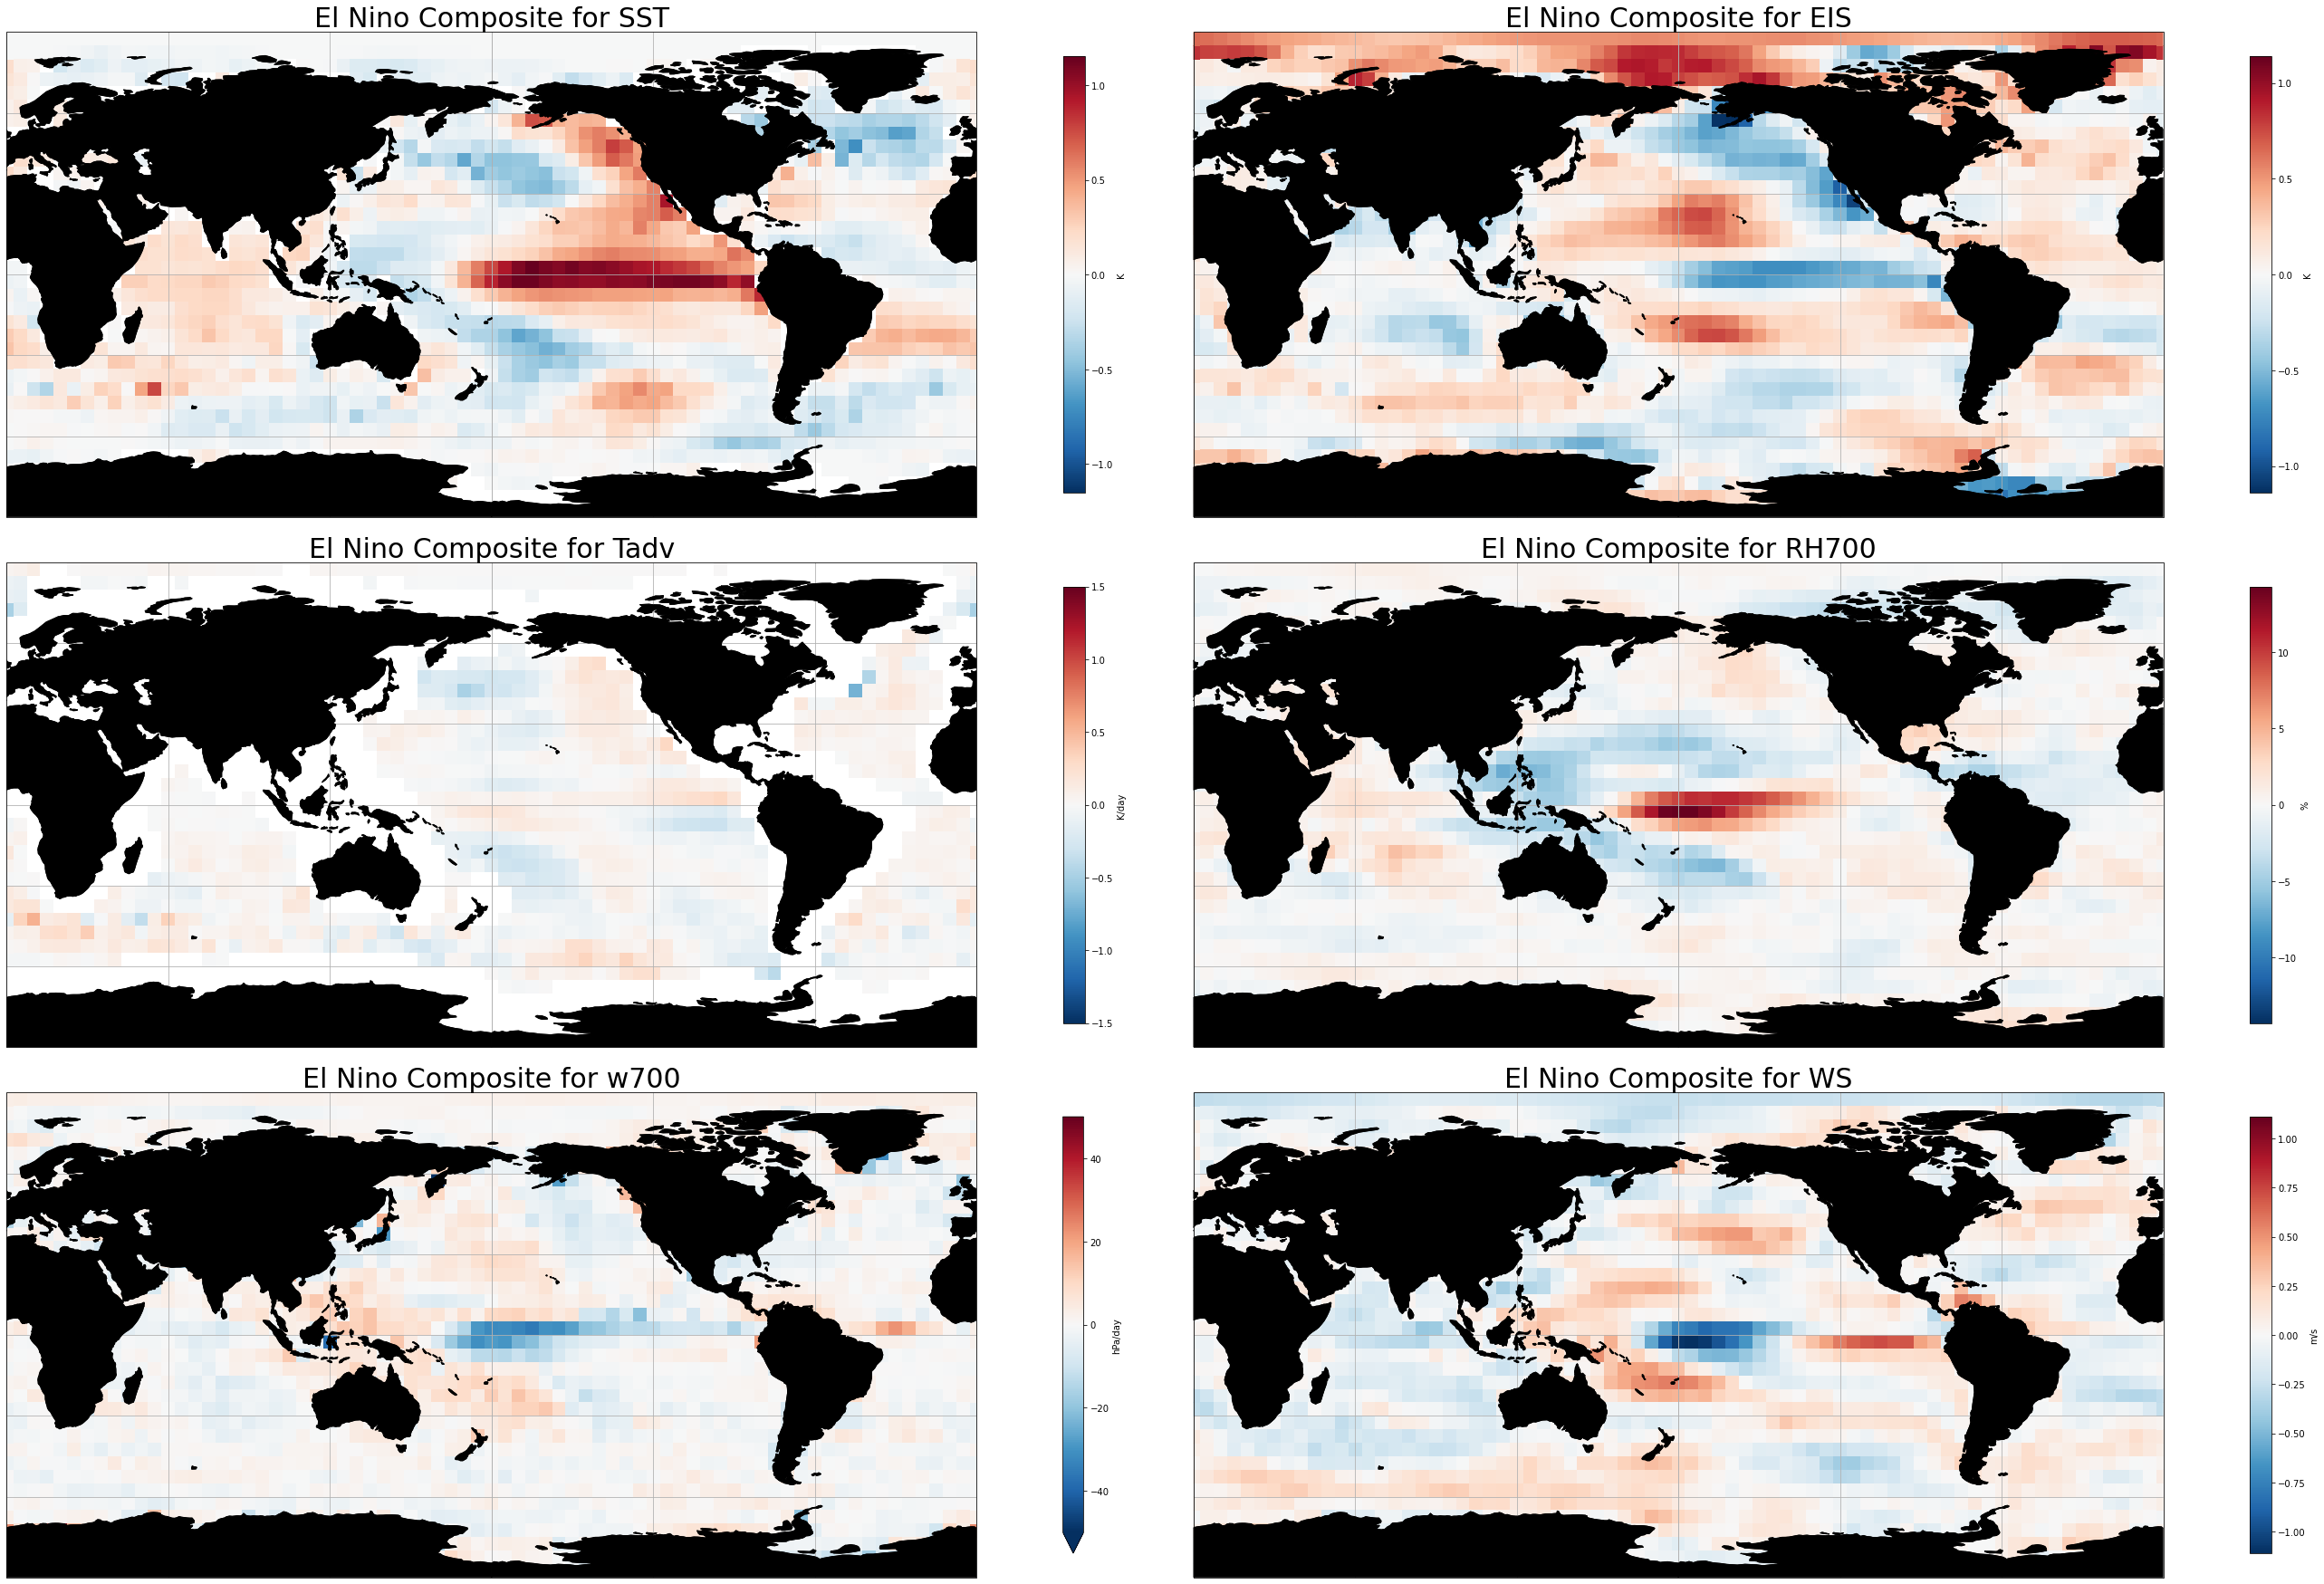

In [34]:
# Get el nino composites for met. param. (SST, EIS, Tadv, RH700, w700, WS)
if plot_enso_composites == 1:
    %run ./get_enso_composites.ipynb
    
    get_enso_composites()

<ipython-input-18-5f123b5171fa>:5: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  kernel_rolled = kernel.assign_coords(longitude=((kernel.longitude % 360) - 2.5)).roll(longitude=(kernel.dims['longitude'] // 2))


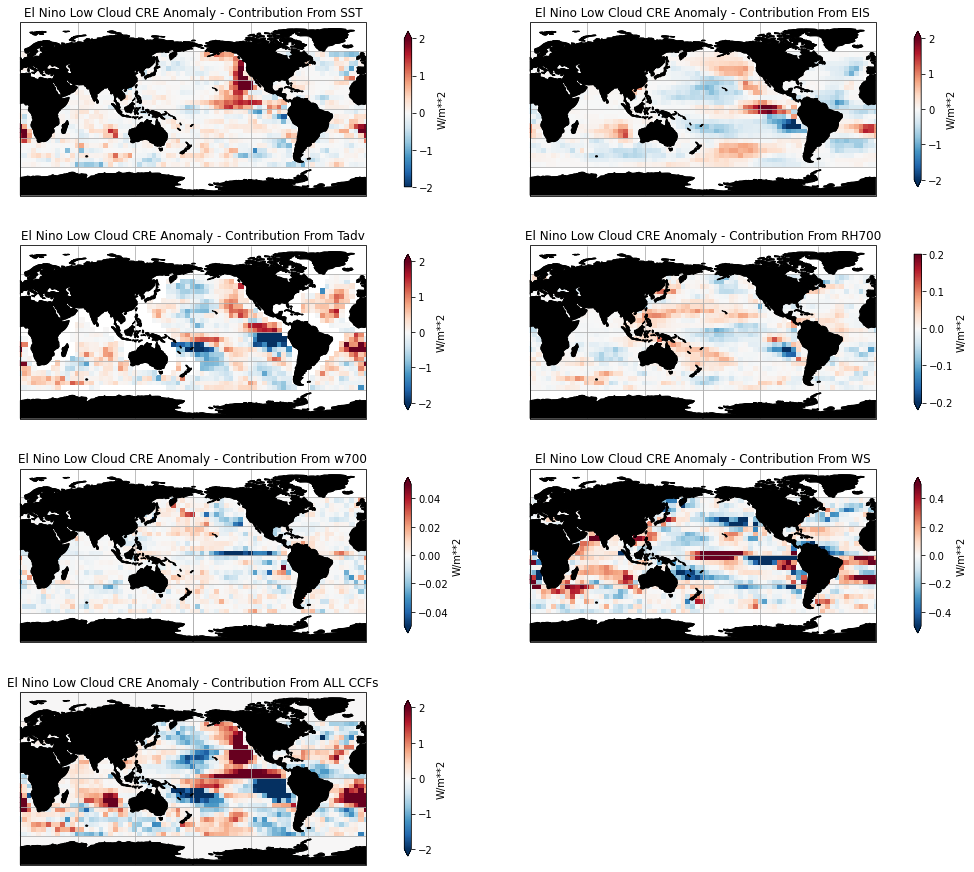

In [18]:
# Get model CRE using el nino composites and Ryan Scott's kernels
if plot_model_cre == 1:
    %run ./get_model_cre.ipynb
    
    get_model_cre()

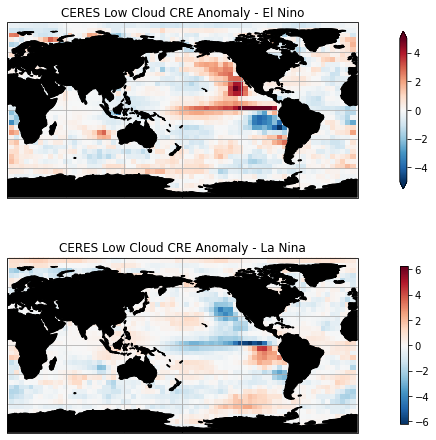

In [20]:
# Get CRE from the CERES-FBCT dataset
if plot_ceres_cre == 1:
    %run ./get_ceres_cre.ipynb
    
    get_ceres_cre()

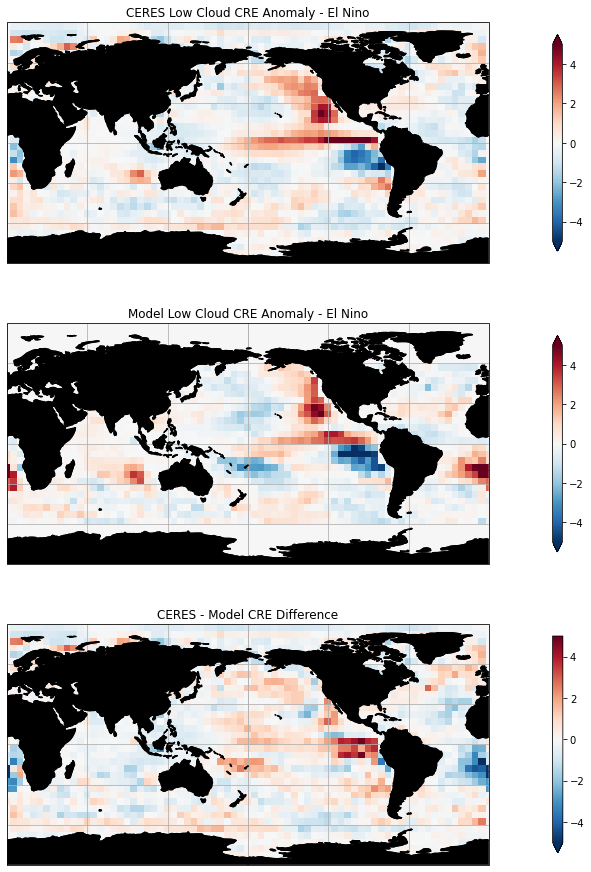

In [21]:
# Compare the CERES CRE and model CRE
if compare_cre == 1:
    %run ./get_compare_cre.ipynb
    
    get_compare_cre()

In [ ]:
#### NASA NIP PROPOSAL PLOTS ####

In [23]:
## Define the nino3.4 region
sst_anom = SST.groupby('time.month') - SST.groupby('time.month').mean(dim='time')
nino34 = sst_anom.sel(latitude=slice(5,-5),longitude=slice(190,240))
nino34_mean = nino34.weighted(weight).mean(dim=('longitude','latitude'))
nino34_rolling = nino34_mean.rolling(time=3,center=True).mean()

/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


In [6]:
## Load in CERES flux datasets
toa_flux = CERES_flux.sel(time=slice('2002-07','2019-12'))
toa_flux['time'] = nino34.time

cld_prop = CERES_cld_prop.sel(time=slice('2002-07','2019-12'))
cld_prop['time'] = nino34.time

path = '/data/keeling/a/tjhanke2/CERES_data/ebaf/'
EBAF_flux = xr.open_mfdataset(path+'CERES_EBAF_Ed4.1_Subset_200003-202011.nc').sel(time=slice('2002-07','2019-12'))
EBAF_flux['time'] = nino34.time

In [7]:
weights = np.cos(np.deg2rad(CERES_flux.lat))

In [8]:
#### GET ATMOSPHERIC VARIABLES (GMST, TOA, loCld CRE, etc...)

In [9]:
def get_mean_across_bins(x_cld,x_clr,cld_area):
    arr = []
    n = int(x_cld.press[0])
    m = int(x_cld.press[-1])
    
    for i in range(n,m):
        for j in range(0,6):            
            # Do calculation in each p,tau bin
            calc = cld_area.sel(press=i,opt=j) * (x_cld.sel(press=i,opt=j) - x_clr)
            
            # Append to arrays
            arr.append(calc)
    
    # Concat each array into DataArrays, and then sum
    calc_da = xr.concat(arr, dim='pressopt')
    calc_xr = calc_da.sum(dim='pressopt')
    
    return calc_xr

In [10]:
## GMST
gmst = sst_anom.weighted(weight).mean(dim=('longitude','latitude'))

## TOA
net = -toa_flux.toa_sw_all_mon - toa_flux.toa_lw_all_mon
net_anom = net.groupby('time.month') - net.groupby('time.month').mean(dim='time')
toa = net_anom.weighted(weights).mean(dim=('lon','lat'))

In [11]:
## low cloud CRE
loCld_frac = cld_prop.cldarea_cldtyp_mon.sel(press=slice(0.0,1.0)) / 100
loCld_frac_anom = loCld_frac.groupby('time.month') - loCld_frac.groupby('time.month').mean(dim='time')

loCld_net_all = (-toa_flux.toa_sw_cldtyp_mon.sel(press=slice(0.0,1.0)) - toa_flux.toa_lw_cldtyp_mon.sel(press=slice(0.0,1.0))).mean(dim='time')
loCld_net_clr = (-toa_flux.toa_sw_clr_mon +-toa_flux.toa_lw_clr_mon).mean(dim='time')

loCld_calc = get_mean_across_bins(loCld_net_all,loCld_net_clr,loCld_frac_anom)
loCld_cre = loCld_calc.weighted(weights).mean(dim=('lat','lon'))

In [12]:
## high cloud CRE
highCld_frac = cld_prop.cldarea_cldtyp_mon.sel(press=slice(2.0,6.0)) / 100
highCld_frac_anom = highCld_frac.groupby('time.month') - highCld_frac.groupby('time.month').mean(dim='time')

highCld_net_all = (-toa_flux.toa_sw_cldtyp_mon.sel(press=slice(2.0,6.0)) - toa_flux.toa_lw_cldtyp_mon.sel(press=slice(2.0,6.0))).mean(dim='time')
highCld_net_clr = (-toa_flux.toa_sw_clr_mon - toa_flux.toa_lw_clr_mon).mean(dim='time')

highCld_calc = get_mean_across_bins(highCld_net_all,highCld_net_clr,highCld_frac_anom)
highCld_cre = highCld_calc.weighted(weights).mean(dim=('lat','lon'))
# highCld_calc = (highCld_net_all - highCld_net_clr) * highCld_frac_anom
# highCld_cre = highCld_calc.sum(dim=('press','opt')).weighted(weights).mean(dim=('lat','lon'))

In [13]:
# net CRE
cld_frac = cld_prop.cldarea_cldtyp_mon / 100
cld_frac_anom = cld_frac.groupby('time.month') - cld_frac.groupby('time.month').mean(dim='time')

net_all = (-toa_flux.toa_sw_cldtyp_mon - toa_flux.toa_lw_cldtyp_mon).mean(dim='time')
net_clr = (-toa_flux.toa_sw_clr_mon - toa_flux.toa_lw_clr_mon).mean(dim='time')

net_calc = get_mean_across_bins(net_all,net_clr,cld_frac_anom)
net_cre = net_calc.weighted(weights).mean(dim=('lat','lon'))
#net_cre = highCld_cre + loCld_cre

In [14]:
## LW CRE
lw_flux = -EBAF_flux.toa_lw_all_mon + EBAF_flux.toa_lw_clr_c_mon
lw_flux_anom = lw_flux.groupby('time.month') - lw_flux.groupby('time.month').mean(dim='time')
lw_cre = lw_flux_anom.weighted(weights).mean(dim=('lon','lat'))

## SW CRE
sw_flux = -EBAF_flux.toa_sw_all_mon + EBAF_flux.toa_sw_clr_c_mon
sw_flux_anom = sw_flux.groupby('time.month') - sw_flux.groupby('time.month').mean(dim='time')
sw_cre = sw_flux_anom.weighted(weights).mean(dim=('lon','lat'))

## net CRE
net_flux_ebaf = EBAF_flux.toa_net_all_mon - EBAF_flux.toa_net_clr_c_mon
net_flux_anom_ebaf = net_flux_ebaf.groupby('time.month') - net_flux_ebaf.groupby('time.month').mean(dim='time')
net_cre_ebaf = net_flux_anom_ebaf.weighted(weights).mean(dim=('lon','lat'))

/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


In [33]:
## Define empty coef matrices (to be filled w/ lagged reg coefs)
gmst_coef = []
toa_coef = []
loCld_cre_coef = []
highCld_cre_coef = []
lw_cre_coef = []
sw_cre_coef = []
net_cre_coef = []

for n in range(-18,19):
    # First, check for any nans after shifting nino3.4 time values, and use it as a mask 
    i = np.isfinite(nino34_rolling.shift(time=n))

    # Use simple linear reg to get coefs for each atmospheric variable
    reg1 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),gmst[i].values)
    reg2 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),toa[i].values)
    reg3 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),loCld_cre[i].values)
    reg4 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),highCld_cre[i].values)
    reg5 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),lw_cre[i].values)
    reg6 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),sw_cre[i].values)
    reg7 = LinearRegression().fit(nino34_rolling.shift(time=n)[i].values.reshape(-1,1),net_cre[i].values)
     
    # Put coefs into empty matrices
    gmst_coef.append(reg1.coef_)
    toa_coef.append(reg2.coef_)
    loCld_cre_coef.append(reg3.coef_)
    highCld_cre_coef.append(reg4.coef_)
    lw_cre_coef.append(reg5.coef_)
    sw_cre_coef.append(reg6.coef_)
    net_cre_coef.append(reg7.coef_)

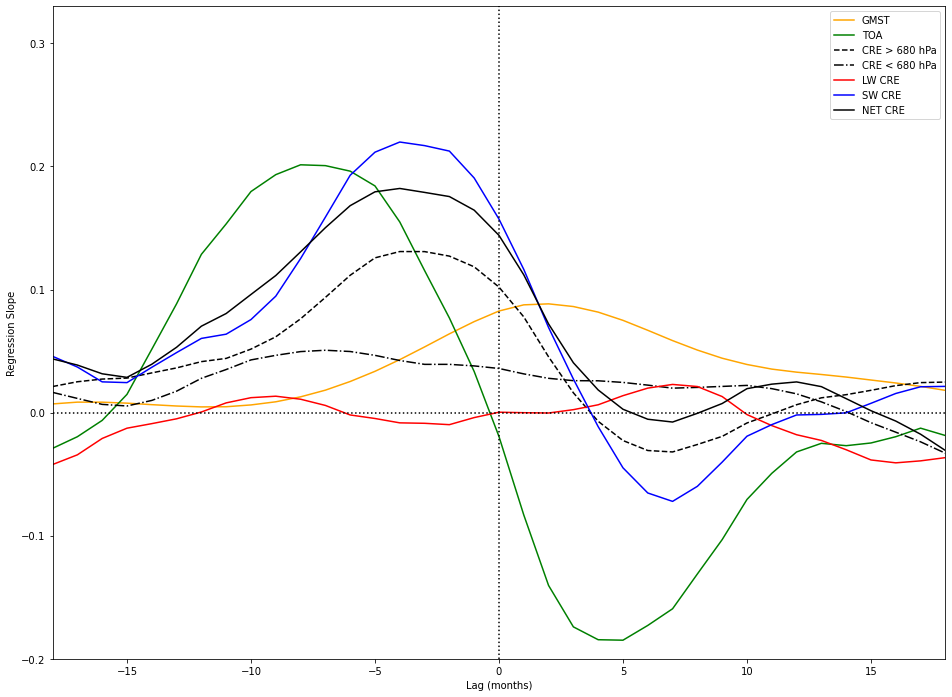

In [34]:
plt.figure(figsize=[16,12])

plt.plot(range(-18,19),gmst_coef,'orange',label='GMST')
plt.plot(range(-18,19),toa_coef,'g',label='TOA')
plt.plot(range(-18,19),loCld_cre_coef,'k', linestyle='dashed',label='CRE > 680 hPa')
plt.plot(range(-18,19),highCld_cre_coef,'k', linestyle='dashdot',label='CRE < 680 hPa')
plt.plot(range(-18,19),lw_cre_coef,'r',label='LW CRE')
plt.plot(range(-18,19),sw_cre_coef,'b',label='SW CRE')
plt.plot(range(-18,19),net_cre_coef,'k',label='NET CRE')

#plt.plot(range(-18,19),np.asarray(sw_cre_coef)+np.asarray(lw_cre_coef),'r', linestyle='dashed',label='CRE > 680 hPa')

plt.axhline(y=0.0, color='k', linestyle='dotted')
plt.axvline(x=0.0, color='k', linestyle='dotted')
plt.xlabel('Lag (months)')
plt.ylabel('Regression Slope')
plt.ylim([-0.2,0.33])
plt.xlim([-18,18])
plt.legend()